## Toxic Comment Classification

Group Project for MSDS621 Machine Learning at University of San Francisco. 

Kaggle competition link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Team members include:
- Xinran (Grace) Zhang
- Shivee Singh
- Neha Tevathia
- Tianqi Wang
- Meng-Ting(Joyce) Chang

## Overview
The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.

### Metrics
There are six labels, the results are evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column. So the performance metrics for the model is AUC of each label.

### Packages

In [10]:
reset -f

In [23]:
import pandas as pd
import numpy as np
import re, string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
# import nltk
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivee/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading data

In [15]:
train  = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
test_y  = pd.read_csv("data/test_labels.csv")

In [13]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [16]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [17]:
train.shape

(159571, 8)

In [18]:
test.shape

(153164, 2)

#### Display the comment length

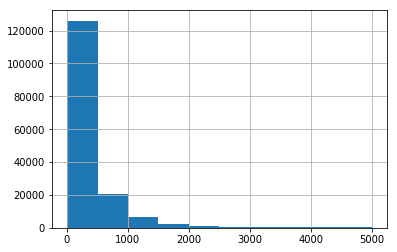

In [19]:
comment_len = train.comment_text.str.len() 
comment_len.hist()

#### Plot the labeled data frequency. There is class imbalance since majority of the comments are clean.

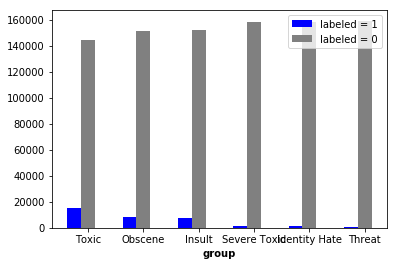

In [20]:
barWidth = 0.25

bars1 = [sum(train['toxic']==1), sum(train['obscene']==1), sum(train['insult']==1), sum(train['severe_toxic']==1),
              sum(train['identity_hate']==1), sum(train['threat']==1)]
bars2 = [sum(train['toxic']==0), sum(train['obscene']==0), sum(train['insult']==0), sum(train['severe_toxic']==0),
              sum(train['identity_hate']==0), sum(train['threat']==0)]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='blue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='grey', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 
                                                      'Threat'])
plt.legend()
plt.show()

In [21]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

It might be a great practice to see which labels are likely to appear together with a comment.

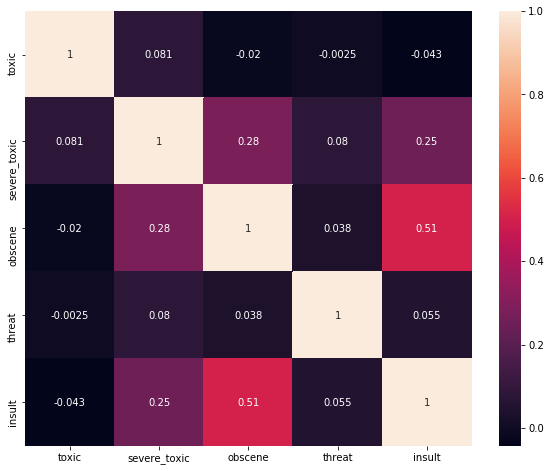

In [22]:
rowsums = train.iloc[:,2:].sum(axis=1)
temp = train.iloc[:,2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

### Words contributing the most to different labels

In [23]:
def W_Cloud(token):
    threat_context = train[train[token] == 1]   
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')             
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

Choose a class  to visualize the most common words contributing to the class:toxic


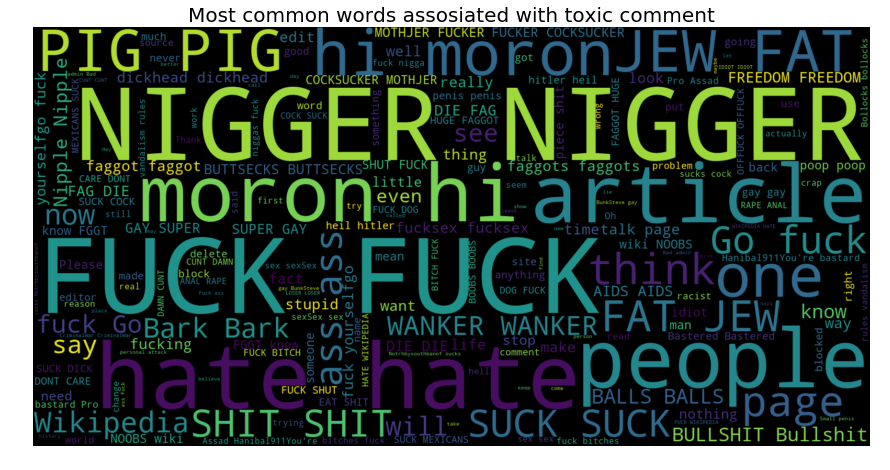

In [24]:
token = input('Choose a class  to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

### Modeling

In [16]:
test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [17]:
def tokenize(text):
    text=text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words=nopunct.split(' ')
    #remove any non ascii 
    words=[word.encode('ascii','ignore').decode('ascii') for word in words]
    lmtzr=WordNetLemmatizer()
    words=[lmtzr.lemmatize(w) for w in words]
    words=[w for w in words if len(w)>2]
    return words

In [18]:
# vect1 = TfidfVectorizer(stop_words='english', ngram_range=(1,2), analyzer = 'word', min_df=10)
# X_train_vec1 = vect1.fit_transform(train['comment_text'])
# X_test_vec1 = vect1.transform(test['comment_text'])

In [19]:
vector = TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
            strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

#### Look at some of the features

In [29]:
vector.get_feature_names()[0:30]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul',
 'abdullah',
 'abe',
 'abel',
 'aberration',
 'abhishek',
 'abhor',
 'abhorrent',
 'abide',
 'abiding',
 'ability',
 'abit']

In [30]:
clf1 = LogisticRegression()
clf2 = MultinomialNB()
clf3 = LinearSVC()

In [31]:
def score(classifier, X_train, y_train, X_test, y_test):
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]
    for label in test_labels:
        
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
    
        auc=roc_auc_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        recall=recall_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        f1=f1_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])

        conf_mat = confusion_matrix(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        methods.append([name,label,auc,recall,f1,conf_mat])
        
    return methods


In [32]:
methods1=pd.DataFrame(score(clf1, X_train, train, X_test, test_y))
methods2=pd.DataFrame(score(clf2, X_train, train, X_test, test_y))
methods3=pd.DataFrame(score(clf3, X_train, train, X_test, test_y))

In [33]:
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model','Label', 'AUC_ROC', 'Recall', 'F1','Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'AUC_ROC', 'Recall', 'F1']]

,Model,Label,AUC_ROC,Recall,F1
0,LogisticRegression,toxic,0.834836,0.710181,0.677900
1,LogisticRegression,severe_toxic,0.648410,0.299728,0.332326
2,LogisticRegression,obscene,0.799131,0.610404,0.674955
3,LogisticRegression,threat,0.577854,0.156398,0.229167
4,LogisticRegression,insult,0.753429,0.517362,0.607608
5,LogisticRegression,identity_hate,0.632029,0.265449,0.382204
6,MultinomialNB,toxic,0.754820,0.532184,0.609440
7,MultinomialNB,severe_toxic,0.529878,0.059946,0.109726
8,MultinomialNB,obscene,0.724772,0.455432,0.587044
9,MultinomialNB,threat,0.500000,0.000000,0.000000


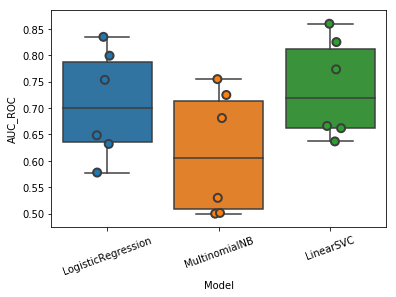

In [34]:
ax = sns.boxplot(x='Model', y='AUC_ROC', data=methods)
sns.stripplot(x='Model', y='AUC_ROC', data=methods, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

plt.show()

### LinearSVC performing better than anyone initially.

Plot for Logistic regression


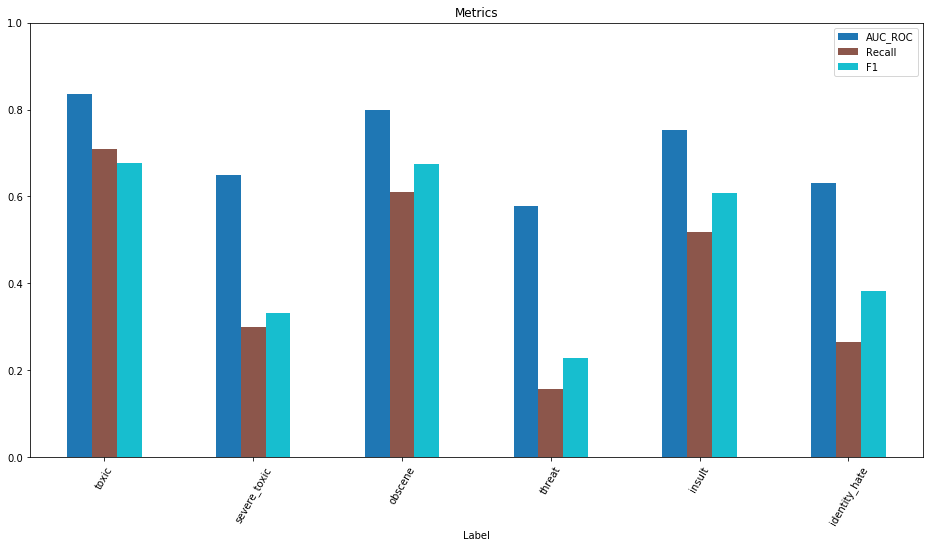

In [35]:
print("Plot for Logistic regression")
m = methods[methods.Model=='LogisticRegression']

m.set_index(["Label"],inplace=True)
%matplotlib inline
m.plot(figsize=(16, 8),kind='bar',title='Metrics', rot=60, ylim=(0.0,1),
             colormap='tab10')

### Model comparison

In [46]:
def drawConfusionMatrix(cm):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
           annot=True,
           annot_kws={"size": 16},
           cmap="YlGnBu",
           fmt='.2f',
           linewidths=2, 
           linecolor='yellow',
           xticklabels=("Non-toxic","Toxic"),
           yticklabels=("Non-toxic","Toxic"))

    plt.ylabel('True',fontsize=18)
    plt.xlabel('Predicted',fontsize=18)
    plt.show()

In [47]:
def Matrix(label):
    print(f"*************** {label} labelling ***************")
    labels = {"toxic":0, "severe_toxic":1, "obscene":2, "threat":3, "insult":4, "identity_hate":5}
    
    pos = labels[label]
    for i in range(pos,len(meth),6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Choose a class for the Confusion Matrix: toxic
*************** toxic labelling ***************

****  LogisticRegression  ***


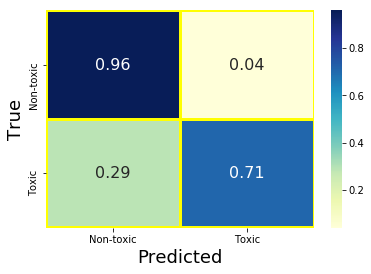


****  MultinomialNB  ***


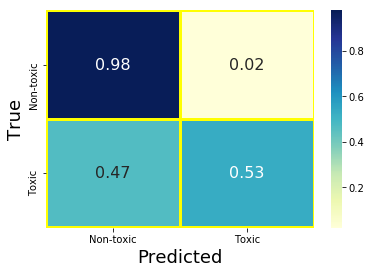


****  LinearSVC  ***


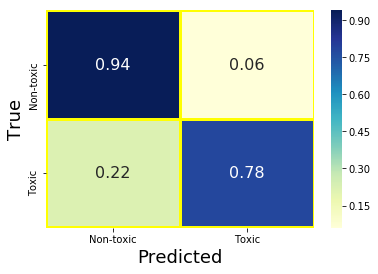

In [48]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

### Pipelines
Let's clean the code with pipeline and use hyperparameters to check how each model behaves.

In [30]:
pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight = {1:20}))
])
  
pipe_rf = Pipeline([
    ('svc', RandomForestClassifier())
])

pipe_mnb = Pipeline([
    ('nb', MultinomialNB())
])

pipelines = [pipe_lr, pipe_linear_svm, pipe_rf, pipe_mnb]

In [31]:
score_df = []
for pipe in pipelines:
    f1_values = [] 
    auc_values = []
    f2_values = []
    recall_values = []
    for label in test_labels:
        pipe.fit(X_train, train[label])
        predicted = pipe.predict(X_test)
    
        auc_values.append(roc_auc_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        f2_values.append(fbeta_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],beta=2,average='weighted'))
        recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    
    val = [name, mean(f1_values), mean(auc_values), mean(f2_values), mean(recall_values)]
    score_df.append(val)  

In [33]:
# Shows mean score for each classifier
scores = pd.DataFrame(score_df,)
scores.columns = ['Model','F1','AUC','F2','Recall']
scores

,Model,F1,AUC,F2,Recall
0,LogisticRegression,0.947951,0.909975,0.937357,0.934087
1,LinearSVC,0.951483,0.843896,0.943924,0.941579
2,RandomForestClassifier,0.968300,0.680043,0.968194,0.968315
3,MultinomialNB,0.968797,0.615328,0.971123,0.973048


Different models are doing well in minizing different types of errors. If we look at Multinomial Naive Bayes it is doing extremely well in terms of Precision. The number of False Positives have been minimized to a great extent. If we look at LinearSVC and Logisitic Classifier , they are doing extremely well in terms of Recall or True Positive Rate. It has minimizing the False Negatives to a great extent.

### LogisticRegression performing the best having AUC score of 91%




### Ensembling : to be continued.....

### Analysis

Analyzing the words misclassified by Logistic Classifier. Checking for 'toxic' label


In [20]:
label='toxic'
lr=LogisticRegression(class_weight="balanced")
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined=pd.concat([test,test_y],axis=1)

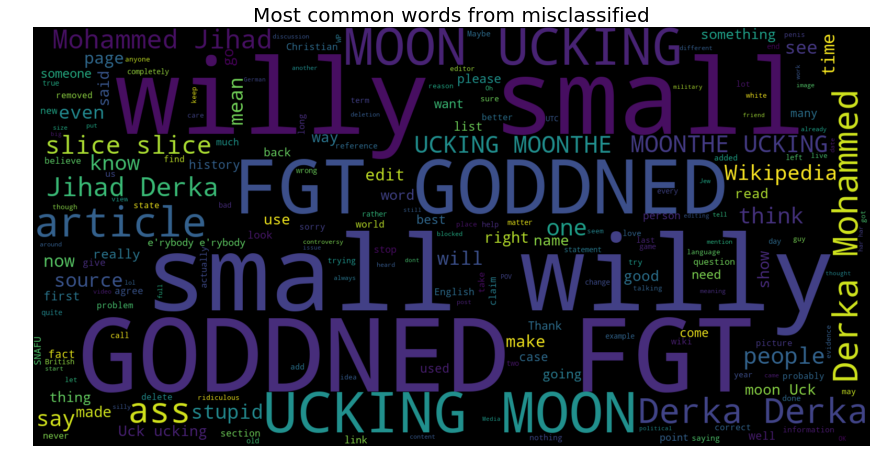

In [80]:

#Misclassified 494 as non-toxic which were actually toxic
#Extract those comments classifier went wrong
commentCheck=test_combined[(test_combined.toxic==1) & (Toxic_LR==0)].comment_text
#Created word cloud of those comments 
neg_Check = pd.Series(commentCheck).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words from misclassified", size=20)
plt.show()



We want to analyze why the model couldnt recognize these words. Were they not present in the training set. 

In order to analyze we first need to pass these raw comment strings through same tokenizer and check the common tokens.

In [87]:
wrongWords=tokenize(neg_Check)
stop_words=stopwords.words('English')
wrongWords=[w for w in wrongWords if w not in stop_words]
cntr=Counter(wrongWords)
cntr.most_common(20)


[('ucking', 253),
 ('small', 238),
 ('willy', 236),
 ('goddned', 226),
 ('fgt', 226),
 ('moon', 197),
 ('derka', 140),
 ('article', 103),
 ('jihad', 72),
 ('mohammed', 71),
 ('slice', 66),
 ('moonthe', 56),
 ('like', 55),
 ('one', 53),
 ('people', 52),
 ('would', 49),
 ('think', 47),
 ('say', 46),
 ('source', 43),
 ('know', 41)]

ucking is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Lets check how frequent was this word in the training data.

In [91]:
neg_text_train=train['comment_text'].str.cat(sep=' ')
cntr_train=Counter(tokenize(neg_text_train))
cntr_train.get('ucking')


5

It is interesting to note that this token wasnt common in our training set. That explains why our model couldnt learn it. 
It also gives us some food for thought on how we can improve our model further.

Lets see the features and whether this word had a high feature importance

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
 
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)